In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Asegurarse de instalar sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
# Asegurarse de instalar el paquete de qiskit_machine_learning
# pip install qiskit-machine-learning
from qiskit_machine_learning.kernels import QuantumKernel

# Estimacion de Kernel Cuantico

Un quantum feature map, $\phi(\mathbf{x})$, naturalmente se presta para construir un *kernel cuantico* $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, que puede ser visto como una metrica de similaridad. $k(\mathbf{x}_i,\mathbf{x}_j)$ es una cantidad grande cuando $\mathbf{x}_i$ y $\mathbf{x}_j$ son similares. 

Cuando consideramos el caso de datos finitos, podemos representar el kernel cuantico como una matriz: 
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$. De esta manera podemos calcular cada elemento en esta matriz mediante el uso de una computadora cuantica calculando la transicion de amplitud:
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$
asumiendo que el feature map es un circuito parameterizado, que puede ser descrito por la transformacion unitaria $\mathbf{U_\phi}(\mathbf{x})$ en $n$ cubits. 

Este cantidad nos provee un estimado de la matriz del kernel cuantico, que podemos utilizar en un algoritmo de machine learning, como clasificacion mediante vectores de soporte.

Como se discute en el articulo [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), los algoritmos de quantum machine learning que utilizan kerneles cuanticos solo tienen posibilidad de demostrar una ventaja cuantica si el kernel cuantico es dificil de estimar mediante metodos clasicos.

Como mencionamos en clase, y comprobaremos mas adelante, la dificultad en la estimacion del kernel con recursos clasicos es simplemente una condicion necesaria, mas no suficiente, para obtener la ventaja cuantica.

Sin embargo, se demostro recientemente en el trabajo de [*Liu et al.* arXiv:2010.02174 (2020)](https://arxiv.org/abs/2010.02174) que existen problemas de aprendizaje para los cuales el acceso a kerneles cuanticos implica una ventaja cuantica sobre metodos clasicos.

Ahora vamos a utilizar los datos que preparamos en el Notebook anterior para implementar la clase `QuantumKernel` mediante el [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html), y utilizaremos el simulador `BasicAer` `statevector_simulator` para entrenar el modelo y verificar las matrices del kernel.

In [2]:
# Empezamos cargando el dataset del modulo 'dataset' de sklearn
digits = datasets.load_digits(n_class=2)

# Crear dos subconjuntos de datos: de entrenamiento y de validacion
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

# Reducir la dimensionalidad mediante el metodo PCA
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalizacion
# Este metodo, es necesario para modelos de tipo support vector, que esperan
# que los datos esten centrados sobre 0.
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Ajustar el rango a -1,1
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Seleccionar 100 elementos del conjunto de entrenamiento y 20 de validacion
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [3]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

Ahora vamos a calcular la amplitud de transicion para los primeros dos elementos en el conjunto de datos de entrenamiento:

In [4]:
print(sample_train[0])
print(sample_train[1])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]
[-0.81630337 -0.2918343  -0.48757339 -0.44903275]


Primero creamos y dibujamos el circuito:

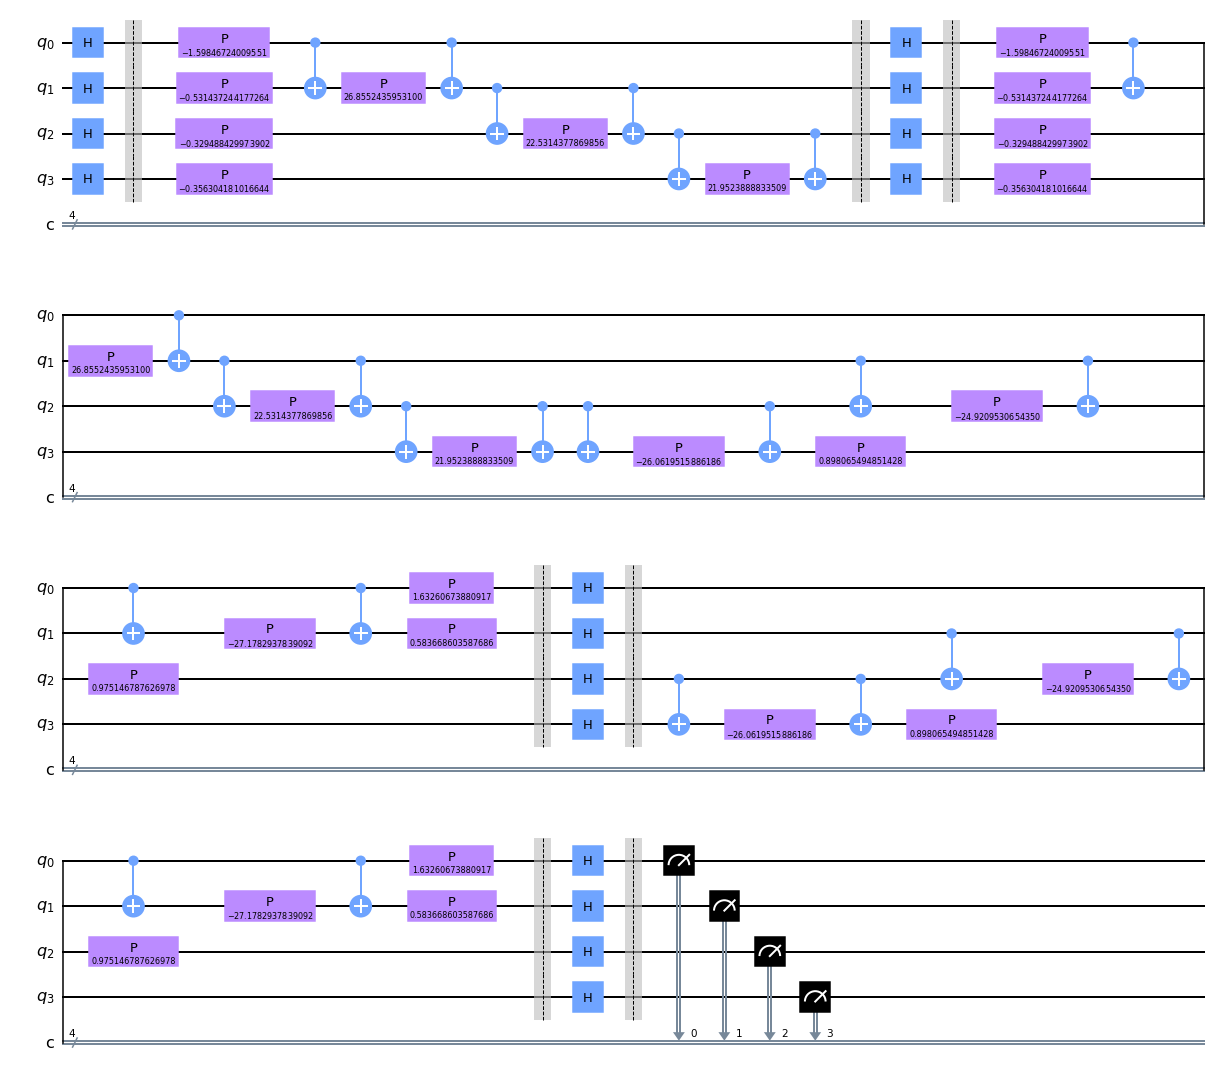

In [5]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

Ahora vamos a simular el circuito. Utilizamos el simulador de `qasm_simulator`, utilizando un numero alto de shots para reducir el efecto de ruido

In [6]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

In [7]:
counts

{'0000': 16,
 '0100': 9,
 '1100': 76,
 '1000': 17,
 '1110': 167,
 '1010': 494,
 '0101': 827,
 '1011': 548,
 '0010': 458,
 '0111': 250,
 '0001': 1650,
 '0011': 455,
 '1101': 138,
 '1111': 736,
 '0110': 221,
 '1001': 2130}

Entonces, la amplitud de transicion es proporcional al numero de cuentas en el estado *all-zero*:

In [8]:
counts['0000']/sum(counts.values())

0.001953125

El proceso se repite para cada par de elementos en el conjunto de datos de entrenamiento, y de esta manera, populamos la matriz del kernel. Como la matriz es simetrica, solo calculamos la mitad de las entradas.

Tambien calculamos la matriz de validacion.

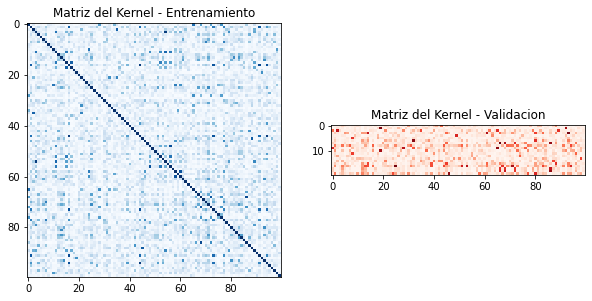

In [9]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("Matriz del Kernel - Entrenamiento")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("Matriz del Kernel - Validacion")
plt.show()

## Clasificacion mediante vectores de soporte cuanticos
Como podemos utilizar este metodo para una tarea de clasificacion?

La version cuantica del metodo de vectores de soporte se introdujo en: [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2) y consiste en los siguientes pasos"

1. Construit y entrenar las matrices del kernel cuantico.
    1. Para cada par de puntos en el conjunto de datos de entrenamiento $\mathbf{x}_{i},\mathbf{x}_j$, aplicamos el feature map y medimos la probabilidad de transicion: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. Para cada elemento $\mathbf{x_i}$ en los datos de entrenamiento y en los datos de validacion: $\mathbf{y_i}$, aplicamos el feature map y medimos la probabilidad de transicion: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Utilizamos estas matrices en un algoritmo clasico de clasificacion mediante vectores de soporte.


El algoritmo `scikit-learn` `svc` nos permite definir un [kernel personalizado](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) de dos maneras: proporcionando el kernel como una funcion que se puede evaluar o calculando el kernel de manera anticipada mediante la clase `QuantumKernel` en Qiskit.

Los siguientes comandos utilizan las matrices del kernel que calculamos anteriormente y las provee al algoritmo `scikit-learn` `svc`:

In [10]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.95


Los siguientes comandos, proveen la matriz de kernel como una funcion evaluable:

In [11]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 0.95


De esta manera, podemos comparar los kernels cuanticos con algunos kernels clasicos:

In [12]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  1.00
poly kernel classification test score:  0.95
rbf kernel classification test score:  1.00
sigmoid kernel classification test score:  1.00


## Ejemplo: Q-SVM para el ad-hoc dataset

In [13]:
import qiskit
import matplotlib.pyplot as plt
import numpy as np
from qiskit.ml.datasets import ad_hoc_data
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

/opt/anaconda3/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/opt/anaconda3/lib/python3.8/site-packages/qiskit/ml/__init__.py:40: DeprecationWarning: The package qiskit.ml is deprecated. It was moved/refactored to qiskit_machine_learning (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('ml', 'qiskit_machine_learning', 'qiskit-machine-learning')


### Datos y Visualizacion

/opt/anaconda3/lib/python3.8/site-packages/qiskit/ml/datasets/ad_hoc.py:79: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  basis = aqua_globals.random.random((2 ** n, 2 ** n)) + \


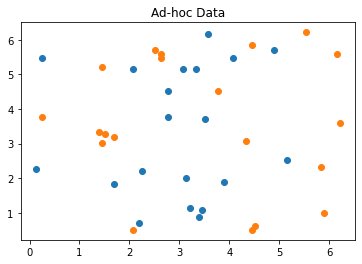

{'A': 0, 'B': 1}


In [14]:
feature_dim = 2
training_dataset_size = 20
testing_dataset_size = 10
random_seed = 10598
shot = 10000
sample_Total, training_input, test_input, class_labels = ad_hoc_data(training_size=training_dataset_size,
                                                                    test_size=testing_dataset_size,
                                                                    gap=0.3,
                                                                    n=feature_dim,
                                                                    plot_data=True)
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
print(class_to_label)

### Ejecutando el algoritmo Q-SVM en dispositivos cuanticos

In [15]:
backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dim, reps=2)
svm = QSVM(feature_map,training_input,test_input,None)
svm.random_seed = random_seed
quantum_instance = QuantumInstance(backend,shots=shot,seed_simulator=random_seed, seed_transpiler=random_seed)
result = svm.run(quantum_instance)

# Nota que para la version mas reciente de Qiskit, se requiere el paquete:
# pip install 'qiskit-aqua[cvx]'

/opt/anaconda3/lib/python3.8/site-packages/qiskit/aqua/algorithms/classifiers/qsvm/qsvm.py:102: DeprecationWarning: The package qiskit.aqua.algorithms.classifiers is deprecated. It was moved/refactored to qiskit_machine_learning.algorithms.classifiers (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.classifiers',
/opt/anaconda3/lib/python3.8/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',


kernel matrix during the training:


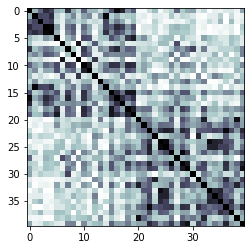

In [16]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')

### Obteniendo predicciones y estimando la precision del modelo

In [17]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels,svm.label_to_class)
print('Etiqueta verdadera: {}'.format(datapoints[1]))
print('Prediccion: {}'.format(predicted_labels))
print('Fracion de exito: ', result['testing_accuracy'])

Etiqueta verdadera: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediccion: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Fracion de exito:  1.0


### Comparando con la version clasica

In [18]:
from qiskit.aqua.algorithms import SklearnSVM
svm_classical = SklearnSVM(training_input, test_input)
result_classical = svm_classical.run()

kernel matrix during the training:


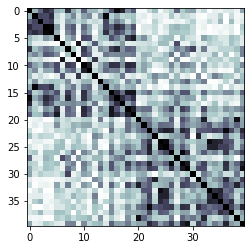

In [19]:
print("kernel matrix during the training:")
kernel_matrix_classical = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix_classical),interpolation='nearest',origin='upper',cmap='bone_r')

In [20]:
predicted_labels_classical = svm_classical.predict(datapoints[0])
predicted_classes_classical = map_label_to_class_name(predicted_labels,svm.label_to_class)
print('ground truth: {}'.format(datapoints[1]))
print('prediction: {}'.format(predicted_labels_classical))
print('testing success ratio: ', result_classical['testing_accuracy'])

ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
prediction: [1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0.]
testing success ratio:  0.55


### Conclusion
Para la tarea de clasificacion, encontrar un hiperplano que segmente nuestros datos en dos categorias no siempre es una tarea facil, en algunos casos, implica una tranformacion a un plano de dimension mayor.

Este paso adicional, añade un grado de dificultad mayor, porque implica el calculo de distancias en un plano de mayor dimension. La alternativa es utilizar el "truco del kernel".

El kernel es una funcion que se puede calcular o evaluar facilmente y que transforma nuestros datos a un espacio de dimension mayor que la original, donde es facil encontrar un plano de decision. Algunas de estas funciones, son dificiles de evaluar clasicamente y aqui es precisamente donde entra la ventaja cuantica.

Cuando los datos son transformados de su formato clasico al espacio de Hilbert donde operan las tranformaciones unitarias que aplicamos en forma de compuertas, esta transformacion a un plano de dimension mayor es aplicada naturalmente, por lo tanto, se espera que el algoritmo cuantico tenga un rendimiento mayor que su contraparte clasica.
